<a href="https://colab.research.google.com/github/sallypatteera/FYP_ctc_detection/blob/main/training/Morphology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:

!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.5/765.5 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.3 MB/s eta 0:00:00


In [ ]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
# Function for contrast enhancement using CLAHE
def enhance_contrast(img):
    # Ensure image is in 8-bit unsigned integer format
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(img)
    return enhanced_img


# Function to apply FFT bandpass filtering
def apply_fft_bandpass(img, low_cutoff, high_cutoff):
    """
    Apply FFT bandpass filtering to an image.
    :param img: Grayscale input image
    :param low_cutoff: Low frequency cutoff (normalized, 0-1)
    :param high_cutoff: High frequency cutoff (normalized, 0-1)
    :return: Filtered image in the spatial domain
    """
    # Perform FFT and shift zero frequency to the center
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    # Create a bandpass mask
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), dtype=np.float32)

    for u in range(rows):
        for v in range(cols):
            dist = np.sqrt((u - crow) ** 2 + (v - ccol) ** 2)
            if low_cutoff * crow < dist < high_cutoff * crow:
                mask[u, v] = 1

    # Apply the mask
    fshift_filtered = fshift * mask

    # Inverse FFT to transform back to spatial domain
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_filtered = np.fft.ifft2(f_ishift)
    img_filtered = np.abs(img_filtered)  # Get magnitude

    return img_filtered

def apply_gaussian_blur(image, kernel_size=(5, 5), sigma=1):
    blurred_image = cv2.GaussianBlur(image, kernel_size, sigma)
    return blurred_image
import cv2
import numpy as np

def calculate_diameter(mask):
    """Calculate the diameter of the mask."""
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        # Calculate the maximum distance between any two points in the contour
        max_distance = 0
        for i in range(len(largest_contour)):
            for j in range(i + 1, len(largest_contour)):
                pt1 = tuple(largest_contour[i][0])
                pt2 = tuple(largest_contour[j][0])
                distance = cv2.norm(np.array(pt1) - np.array(pt2))
                max_distance = max(max_distance, distance)
        return max_distance
    return 0  # Return 0 if no contours found

def calculate_circularity(mask):
    """Calculate the circularity of the mask."""
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)
        if perimeter > 0:
            circularity = (4 * np.pi * area) / (perimeter ** 2)
            return circularity
    return 0  # Return 0 if no contours found

Morphology Function

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import supervision as sv
from skimage import measure
from scipy import ndimage as ndi

def process_images(image_folder, output_csv, missing_masks_csv, pixels_to_um=0.288, diameter_threshold=300, circularity_threshold=0.5):
    results_df = pd.DataFrame(columns=["Images Name"])
    missing_masks_df = pd.DataFrame(columns=["Missing Image Name"])  # DataFrame for images without masks

    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg"):
            img_path = os.path.join(image_folder, filename)

            img_gray = cv2.imread(img_path, 0)
            if img_gray is None:
                print(f"Warning: {filename} not found or could not be loaded")
                continue

            blurred_img = apply_gaussian_blur(img_gray, kernel_size=(5, 5), sigma=1)
            enhanced_img = enhance_contrast(blurred_img)
            image_rgb = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB)
            min_diameter = 0.4 * max(image_rgb.shape)  # Mask > 40% of image shape ratio

            sam_result = mask_generator.generate(image_rgb)
            mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

            detections = sv.Detections.from_sam(sam_result=sam_result)

            annotated_image = mask_annotator.annotate(scene=image_rgb.copy(), detections=detections)

            filtered_masks = []
            masks = [
                mask['segmentation']
                for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)
            ]
            for mask in masks:
                diameter = calculate_diameter(mask)
                circularity = calculate_circularity(mask)

                if min_diameter < diameter < max(image_rgb.shape) and circularity > circularity_threshold:
                    filtered_masks.append(mask)

            print(f"Number of filtered masks: {len(filtered_masks)}")
            print(f"Image shape: ", img_gray.shape)
            print(f"Image name: ", filename)

            # Measure the first filtered mask only
            if filtered_masks:
                first_mask = filtered_masks[0]  # Get the first filtered mask
                circularity = calculate_circularity(first_mask)
                diameter = calculate_diameter(first_mask)
                print(f"Diameter final: {diameter}, Circularity final: {circularity}")
                labeled_image = measure.label(first_mask)

                # Extract features
                feature = measure.regionprops_table(
                    labeled_image,
                    properties=('label', 'area', 'centroid',
                                'major_axis_length', 'minor_axis_length',
                                'orientation', 'perimeter', 'eccentricity')
                ) # 'equivalent_diameter'

                features_df = pd.DataFrame(feature)
                features_df['Image Name'] = filename  # Add image name to the features DataFrame
                features_df['Circularity'] = circularity
                # Convert properties in the DataFrame
                features_df['area'] = features_df['area'] * (pixels_to_um ** 2)  # Convert area to um^2
                for prop in ['perimeter', 'centroid-0', 'centroid-1',
                            'major_axis_length',
                             'minor_axis_length', 'orientation']: #  'equivalent_diameter',
                    features_df[prop] = features_df[prop] * pixels_to_um  # Convert other properties to um

                # Append only the first row of features_df to results_df
                results_df = pd.concat([results_df, features_df.iloc[[0]]], ignore_index=True)

            else:
                # If no masks are found, save the image name to missing_masks_df
                missing_masks_df = pd.concat([missing_masks_df, pd.DataFrame({"Missing Image Name": [filename]})], ignore_index=True)

            # Visualization section
            fig, ax = plt.subplots(1, 2, figsize=(5, 2.5))
            ax[0].imshow(image_rgb, cmap='gray')
            ax[0].set_title("Preprocessed Image")

            if filtered_masks:
                ax[1].imshow(filtered_masks[0], cmap='gray')  # Display the first mask
                ax[1].set_title("Filtered Mask")
            else:
                ax[1].imshow(np.zeros((371, 370), dtype=np.uint8), cmap='gray')
                ax[1].set_title("No Masks Available")

            plt.tight_layout()
            plt.show()

    # Save the results DataFrame to a file
    results_df.to_csv(output_csv, index=False)
    # Save the missing masks DataFrame to a separate file
    missing_masks_df.to_csv(missing_masks_csv, index=False)



# skimage.measure definition
**label** : The label in the labeled input image.

**area**: Surface area of mesh. Units now [coordinate units] ** 2.

**centroid**: Return the (weighted) centroid of an image.

**equivalent_diameter**: The diameter of a circle with the same area as the region.

**major_axis_length** : The length of the major axis of the ellipse that has the same normalized second central moments as the region.

**minor_axis_length** : The length of the minor axis of the ellipse that has the same normalized second central moments as the region.

**orientation** : Angle between the 0th axis (rows) and the major axis of the ellipse that has the same second moments as the region, ranging from -pi/2 to pi/2 counter-clockwise.

**perimeter**: Calculate total perimeter of all objects in binary image.

**eccentricity**: Eccentricity of the ellipse that has the same second-moments as the region. The eccentricity is the ratio of the focal distance (distance between focal points) over the major axis length. The value is in the interval [0, 1). When it is 0, the ellipse becomes a circle.

# Crop HEYA8

Number of filtered masks: 1
Image shape:  (271, 260)
Image name:  tile_x009_y008_jpg.rf.958f0ec66eecb0b18fa0e7386495af03_26_0324_2.jpg
Diameter final: 246.59480935331953, Circularity final: 0.7495863273814056


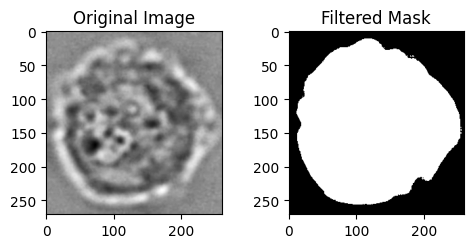

Number of filtered masks: 1
Image shape:  (266, 244)
Image name:  tile_x002_y003_jpg.rf.9e6e186f45ca3566580090697dda9d5d_6_0324_1.jpg
Diameter final: 209.74508337503408, Circularity final: 0.7723980571018157


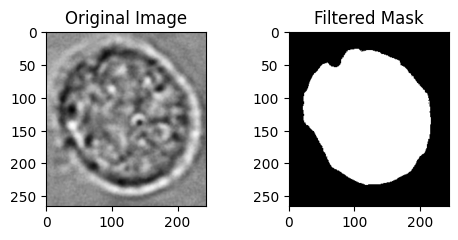

Number of filtered masks: 1
Image shape:  (270, 269)
Image name:  tile_x015_y004_jpg.rf.d5e6bed397b6132bb5603c736d68305e_18_0324_2.jpg
Diameter final: 220.53117693423758, Circularity final: 0.8476581319730402


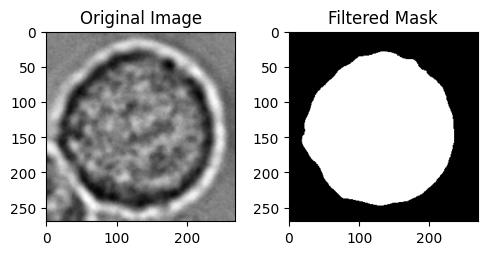

Number of filtered masks: 1
Image shape:  (400, 380)
Image name:  tile_x001_y012_jpg.rf.c2ea966ffa7c8ff09a3a4df17ecb9271_12_0324_1.jpg
Diameter final: 361.58124951385406, Circularity final: 0.8498147680164557


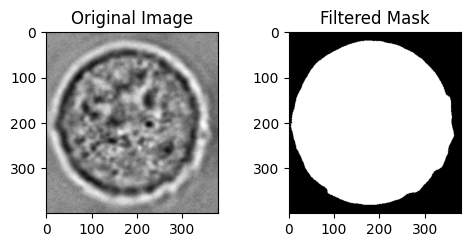

Number of filtered masks: 0
Image shape:  (317, 300)
Image name:  tile_x014_y004_jpg.rf.286ad92d097956d521791ba86988cc9f_5_0324_2.jpg


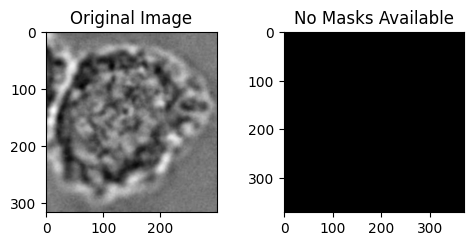

Number of filtered masks: 1
Image shape:  (315, 309)
Image name:  tile_x007_y004_jpg.rf.92187c16d1062a837a8cd7eb5a7d25d1_15_0324_2.jpg
Diameter final: 256.09568524284043, Circularity final: 0.7415426522730626


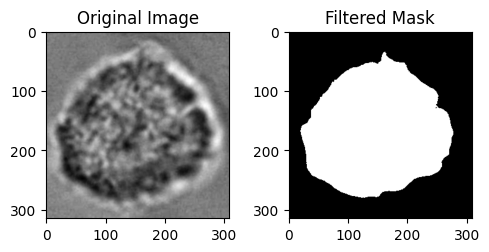

Number of filtered masks: 1
Image shape:  (337, 323)
Image name:  tile_x013_y005_jpg.rf.47cfabcfcf9f4a3572f150c1c748eb32_8_0324_2.jpg
Diameter final: 318.3237345847777, Circularity final: 0.8339969963922838


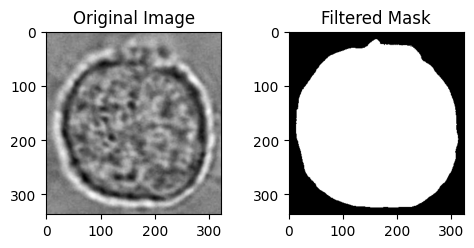

Number of filtered masks: 1
Image shape:  (318, 321)
Image name:  tile_x015_y004_jpg.rf.d5e6bed397b6132bb5603c736d68305e_10_0324_2.jpg
Diameter final: 307.2474572718219, Circularity final: 0.8102469738180571


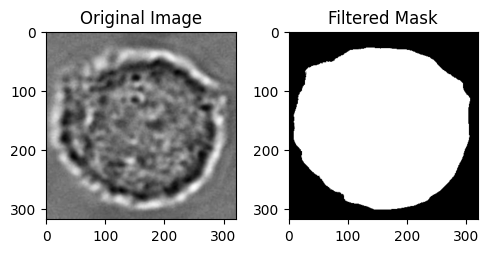

KeyboardInterrupt: 

In [ ]:
image_folder = "/content/drive/Shareddrives/FYP/Morphology/all images/HEYA8"
output_csv = "/content/drive/Shareddrives/FYP/Morphology/morphology_results/morphology_result_HEYA8.csv"
missing_masks_csv = "/content/drive/Shareddrives/FYP/Morphology/morphology_results/missing_masks_HEYA8.csv"
process_images(image_folder, output_csv, missing_masks_csv)

# Crop A549

Number of filtered masks: 1
Image shape:  (251, 262)
Image name:  tile_x009_y003_jpg.rf.5b302aba6ceddfa74383f80919cb8ee7_16.jpg
Diameter final: 203.30272993740147, Circularity final: 0.853817366657768


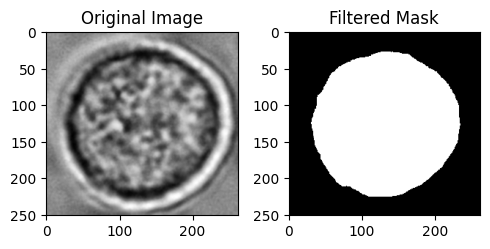

Number of filtered masks: 2
Image shape:  (252, 259)
Image name:  tile_x009_y002_jpg.rf.6a956f525d5166b251d7da2ad54b432f_7.jpg
Diameter final: 254.23807739990482, Circularity final: 0.8662828628228155


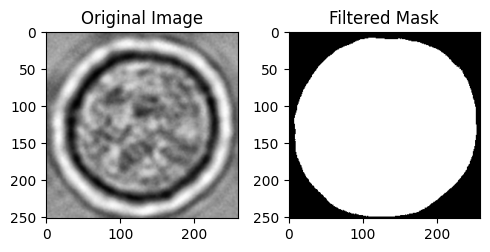

Number of filtered masks: 2
Image shape:  (235, 241)
Image name:  tile_x005_y014_jpg.rf.8b63f343e2cda19fb10af6e05e58b8f2_6.jpg
Diameter final: 235.83468786419016, Circularity final: 0.8891973968263959


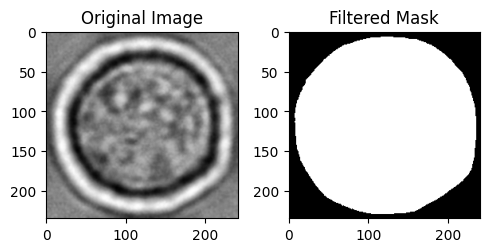

Number of filtered masks: 0
Image shape:  (259, 270)
Image name:  tile_x002_y006_jpg.rf.60b04ce7709de66307999a7b7bf534fd_13.jpg


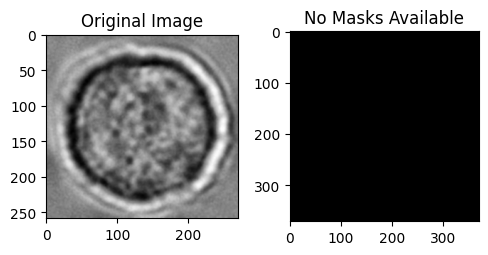

Number of filtered masks: 2
Image shape:  (294, 293)
Image name:  tile_x011_y0082.jpg
Diameter final: 256.46247288833507, Circularity final: 0.8510980598636088


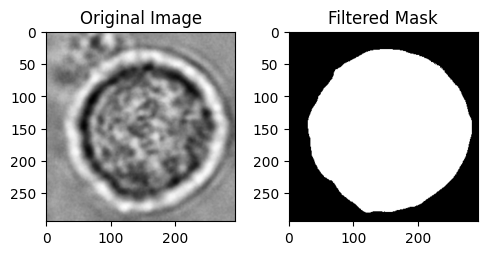

KeyboardInterrupt: 

In [ ]:
# image_folder = "/content/drive/MyDrive/single_cell_data/All images/A549"
# output_csv = "/content/drive/MyDrive/morphology_results/morphology_result_A549.csv"
# missing_masks_csv = "/content/drive/MyDrive/morphology_results/missing_masks_A549.csv"


image_folder = "/content/drive/Shareddrives/FYP/Morphology/all images/A549"
output_csv = "/content/drive/Shareddrives/FYP/Morphology/morphology_results/morphology_result_A549.csv"
missing_masks_csv = "/content/drive/Shareddrives/FYP/Morphology/morphology_results/missing_masks_A549.csv"
process_images(image_folder, output_csv, missing_masks_csv)

# Crop T24

Number of filtered masks: 1
Image shape:  (271, 273)
Image name:  tile_x005_y005_jpg.rf.90808ba4a4ecb7e122af0b68a60833ec_4_0227.jpg
Diameter final: 219.92044015961773, Circularity final: 0.8467331966053294


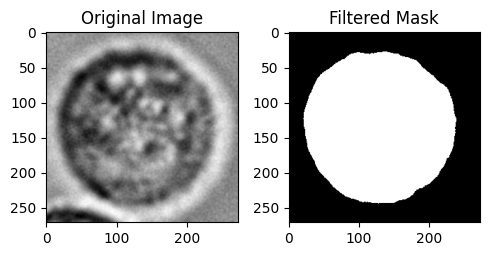

Number of filtered masks: 1
Image shape:  (316, 325)
Image name:  tile_x003_y006_jpg.rf.e389cfc8b4a4052fd2f3ca0677f32722_6_0227.jpg
Diameter final: 265.13581425375185, Circularity final: 0.8444043325760395


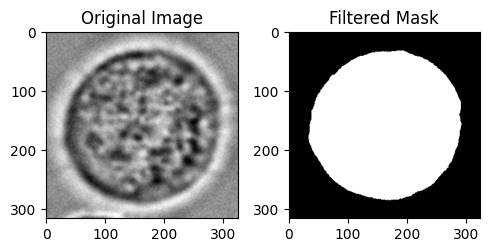

Number of filtered masks: 1
Image shape:  (267, 252)
Image name:  tile_x006_y011_jpg.rf.9dbc3a52f2dd1aa16d6ba99853d05797_5_0227.jpg
Diameter final: 200.44949488586894, Circularity final: 0.8601419551497649


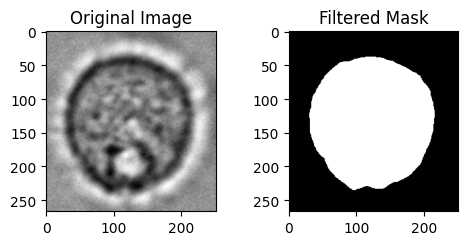

Number of filtered masks: 1
Image shape:  (270, 270)
Image name:  tile_x010_y008_jpg.rf.eed7e492030a0383a1dd972a1e805236_9_0227_2.jpg
Diameter final: 223.3942702935776, Circularity final: 0.8632086378903288


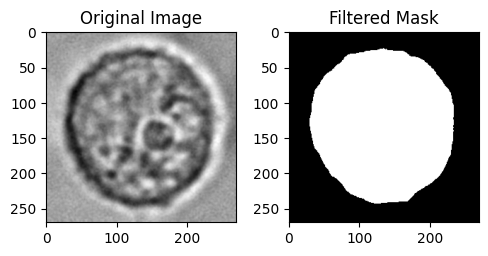

Number of filtered masks: 1
Image shape:  (230, 220)
Image name:  tile_x011_y013_jpg.rf.3f21131aa19d5a3a2bd97f9225ee1f6c_7_0227_2.jpg
Diameter final: 187.83237207680682, Circularity final: 0.8379378279110882


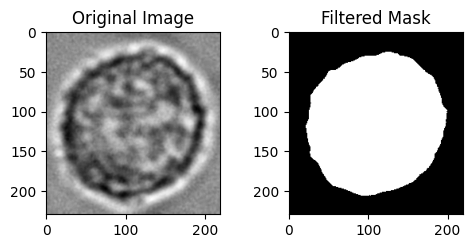

Number of filtered masks: 1
Image shape:  (302, 314)
Image name:  tile_x006_y011_jpg.rf.9dbc3a52f2dd1aa16d6ba99853d05797_10_0227.jpg
Diameter final: 260.76809620810593, Circularity final: 0.6785065956370796


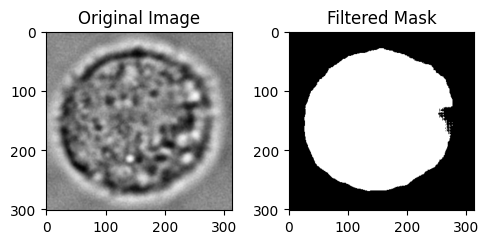

Number of filtered masks: 1
Image shape:  (250, 267)
Image name:  tile_x007_y007_jpg.rf.c8625940834cf3f37232731faa1d9dac_4_0227_2.jpg
Diameter final: 233.0407689654323, Circularity final: 0.7989827989592221


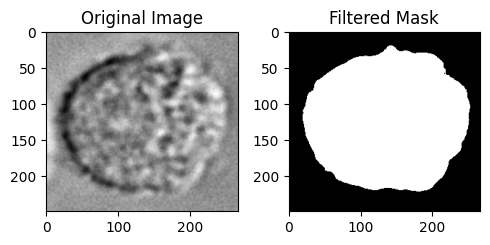

KeyboardInterrupt: 

In [ ]:
# image_folder = "/content/drive/MyDrive/single_cell_data/All images/T24"
# output_csv = "/content/drive/MyDrive/morphology_results/morphology_result_T24.csv"
# missing_masks_csv = "/content/drive/MyDrive/morphology_results/missing_masks_T24.csv"

image_folder = "/content/drive/Shareddrives/FYP/Morphology/all images/T24"
output_csv = "/content/drive/Shareddrives/FYP/Morphology/morphology_results/morphology_result_T24.csv"
missing_masks_csv = "/content/drive/Shareddrives/FYP/Morphology/morphology_results/missing_masks_T24.csv"
process_images(image_folder, output_csv, missing_masks_csv)

# Crop H2452

Number of filtered masks: 0
Image shape:  (291, 282)
Image name:  tile_x006_y014_jpg.rf.dfbde675012c4771da59ec0daaa11061_2.jpg


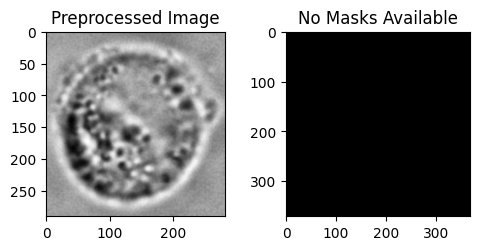

Number of filtered masks: 1
Image shape:  (239, 251)
Image name:  tile_x001_y006_jpg.rf.1b5d562b1810c38cd3f9d65e7f1bc2e5_22.jpg
Diameter final: 198.94974239742055, Circularity final: 0.8230259292443866


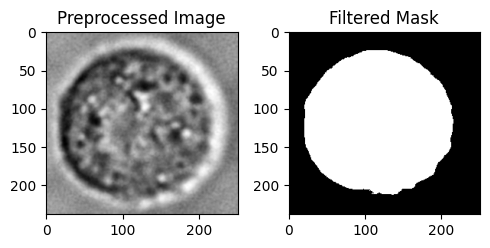

Number of filtered masks: 1
Image shape:  (295, 287)
Image name:  tile_x006_y001_jpg.rf.d1411a876024df52c17a39ea1c0da721_4.jpg
Diameter final: 242.2973379961076, Circularity final: 0.7983717398787543


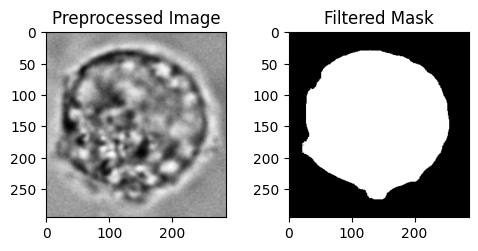

KeyboardInterrupt: 

In [ ]:
# image_folder = "/content/drive/MyDrive/single_cell_data/All images/H2452"
# output_csv = "/content/drive/MyDrive/morphology_results/morphology_result_H2452.csv"
# missing_masks_csv = "/content/drive/MyDrive/morphology_results/missing_masks_H2452.csv"

image_folder = "/content/drive/Shareddrives/FYP/Morphology/all images/H2452"
output_csv = "/content/drive/Shareddrives/FYP/Morphology/morphology_results/morphology_result_H2452.csv"
missing_masks_csv = "/content/drive/Shareddrives/FYP/Morphology/morphology_results/missing_masks_H2452.csv"
process_images(image_folder, output_csv, missing_masks_csv)

# Machine Learning

In [ ]:
from numpy import absolute
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
data = pd.read_csv("/content/drive/Shareddrives/FYP/Morphology/morphology_results/morphology_result_all_cells.csv")
x = data.iloc[:,[ 1, 2, 3,4,5,6,7,8,10]]
y = data['label']

In [ ]:
y

,label
0,0
1,0
2,0
3,0
4,0
...,...
5915,3
5916,3
5917,3
5918,3


In [ ]:
x

,area,centroid-0,centroid-1,major_axis_length,minor_axis_length,orientation,perimeter,eccentricity,Circularity
0,3024.88,38.95,36.86,62.62,61.56,0.24,210.97,0.18,0.85
1,4214.47,45.64,47.29,74.95,71.63,-0.30,249.52,0.29,0.84
2,2375.52,38.66,35.23,56.71,53.45,0.00,185.39,0.33,0.86
3,2899.47,38.06,38.16,63.00,58.68,0.06,204.55,0.36,0.86
4,2028.48,33.42,31.27,52.83,48.95,-0.19,173.49,0.38,0.84
...,...,...,...,...,...,...,...,...,...
5915,3553.40,37.04,35.14,68.28,66.30,0.10,229.16,0.24,0.84
5916,3124.42,40.12,40.05,65.79,60.51,0.21,214.47,0.39,0.85
5917,4781.31,42.18,41.61,80.14,76.01,0.41,268.81,0.32,0.83
5918,3857.06,43.76,41.73,71.19,69.00,0.13,235.66,0.25,0.87


1480 for each

HEYA8 = 0
T24 = 1
H2452 = 2
A549 = 3

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
clf=XGBClassifier()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6058558558558559


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Create a Random Forest classifier
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6148648648648649


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=100, activation='relu', solver='adam', random_state=1)

# Train the MLP model on the training data
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.33614864864864863


In [ ]:
from sklearn.svm import SVC
from sklearn import metrics

clf = SVC()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.38175675675675674


In [ ]:
clf=XGBClassifier(objective='multi:softmax',
                            num_class=4, # liver, lung, breast
                  learning_rate=  0.4185 ,
                  n_estimators= int(18.65))
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6193693693693694


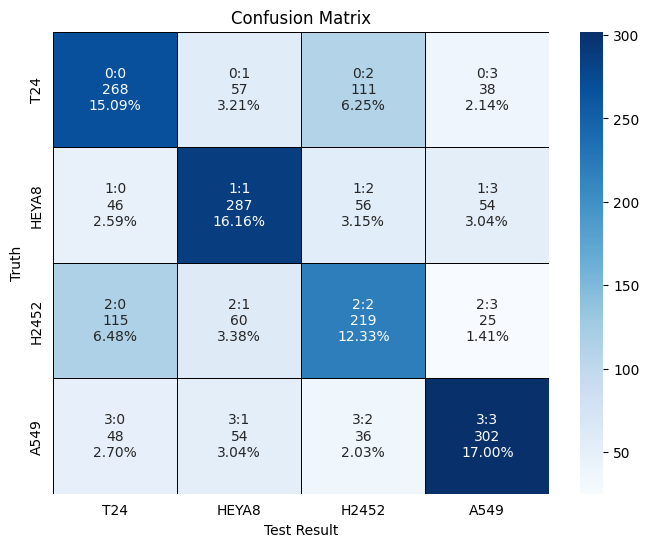

In [ ]:
cf = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3])
group_names = ["0:0", "0:1", "0:2", "0:3",
               "1:0", "1:1", "1:2", "1:3",
               "2:0", "2:1", "2:2", "2:3",
               "3:0", "3:1", "3:2", "3:3"]
group_counts = ["{0:0.0f}".format(value) for value in cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(4, 4)  # Change to 4x4 for 4 classes

x_axis_labels = ["T24", "HEYA8", "H2452", "A549"]  # labels for x-axis
y_axis_labels = ["T24", "HEYA8", "H2452", "A549"]  # labels for y-axis

plt.figure(figsize=(8, 6))  # Optional: Adjust figure size
ax = sns.heatmap(cf, annot=labels, fmt="", cmap='Blues', linecolor='black',
                 xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidths=.5)
ax.tick_params(left=False, bottom=False)

ax.set(xlabel='Test Result', ylabel='Truth')
plt.title('Confusion Matrix')  # Optional: Add a title
plt.show()

Feature importance quantifies the contribution of each feature (or variable) in predicting the output of a model. It helps in understanding which variables are driving the predictions and can guide feature selection, interpretation, and model improvement.

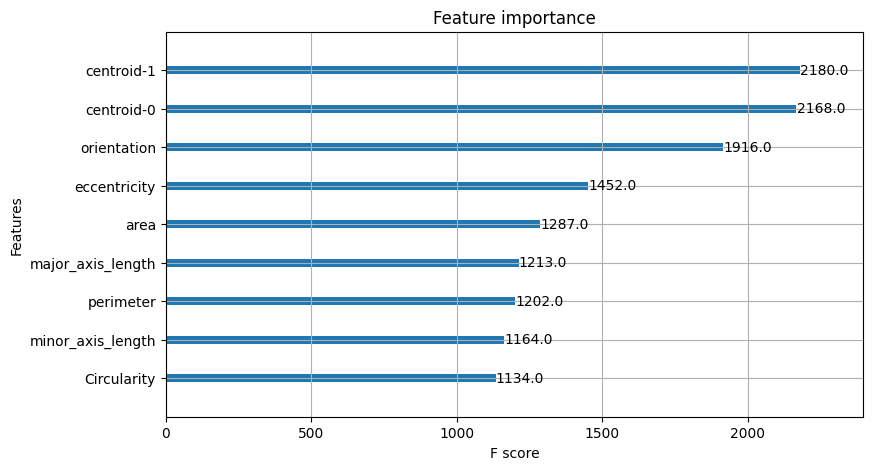

In [ ]:
#Features Importance
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(9,5))
plot_importance(clf, ax=ax)
plt.show()

<ipython-input-33-2b4ff854af55>:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(ax=axes[0, 0], x="area", data=data, palette="Set3")
<ipython-input-33-2b4ff854af55>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(ax=axes[0, 1], x="centroid-0", data=data, palette="Set3")
<ipython-input-33-2b4ff854af55>:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(ax=axes[1, 0], x="centroid-1", data=data, palette="Set3")
<ipython-input-33-2b4ff854af55>:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(ax=axes[1, 1], x="major_axis_length", data=data, palette="Set3")
<ipython-input-33-2b4ff854af55>:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(ax=axes[2, 0], x="minor_axis_length", data=data, palette="Set3")
<ipython-input-33-2b4ff854af55>:13: UserWarning: Ignoring `palet

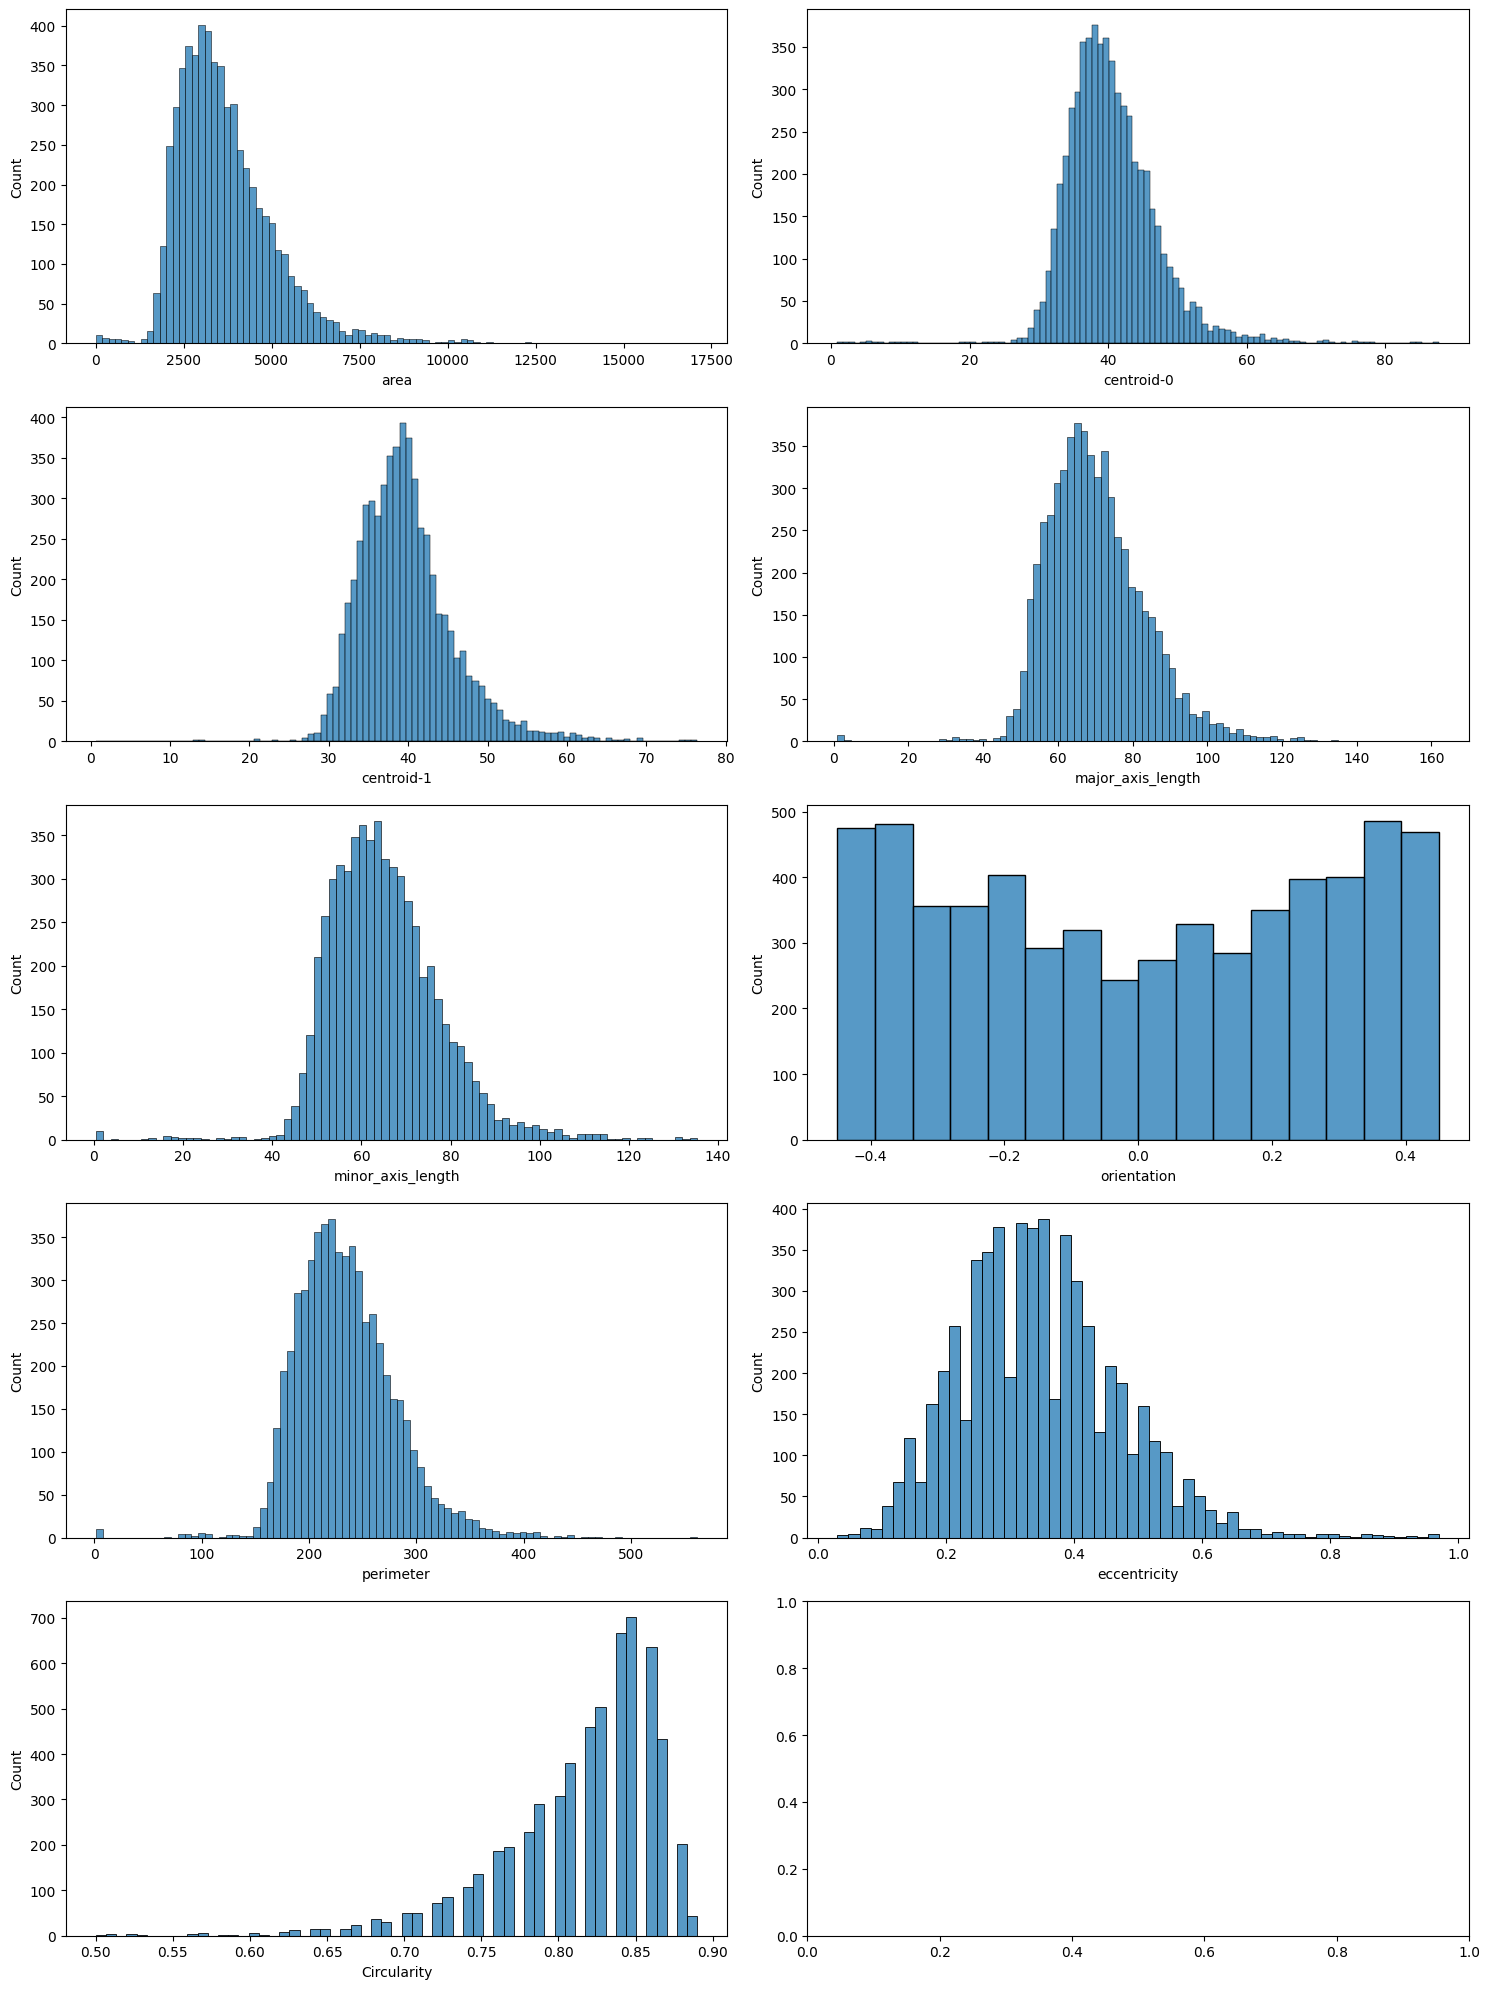

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your DataFrame containing the features
fig, axes = plt.subplots(5, 2, figsize=(15, 20), sharey=False)

# Plotting the specified features
sns.histplot(ax=axes[0, 0], x="area", data=data, palette="Set3")
sns.histplot(ax=axes[0, 1], x="centroid-0", data=data, palette="Set3")
sns.histplot(ax=axes[1, 0], x="centroid-1", data=data, palette="Set3")
sns.histplot(ax=axes[1, 1], x="major_axis_length", data=data, palette="Set3")
sns.histplot(ax=axes[2, 0], x="minor_axis_length", data=data, palette="Set3")
sns.histplot(ax=axes[2, 1], x="orientation", data=data, palette="Set3")
sns.histplot(ax=axes[3, 0], x="perimeter", data=data, palette="Set3")
sns.histplot(ax=axes[3, 1], x="eccentricity", data=data, palette="Set3")
sns.histplot(ax=axes[4, 0], x="Circularity", data=data, palette="Set3")

# Adjust layout
plt.tight_layout()

# Save the figure
fig.savefig("distribution.png")

**Skewness**: If any of the distributions are skewed (left or right), it indicates that most data points are concentrated on one side of the scale.

**Peaks**: The location and height of the peaks reveal the most common values for each feature.

**Spread**: The width of the histograms can indicate variability or consistency among the measurements.

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Print Accuracy and Balanced Accuracy
print(f'\nAccuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.2f}\n')

# Micro-average metrics
print(f'Micro Precision: {precision_score(y_test, y_pred, average="micro"):.2f}')
print(f'Micro Recall: {recall_score(y_test, y_pred, average="micro"):.2f}')
print(f'Micro F1-score: {f1_score(y_test, y_pred, average="micro"):.2f}\n')

# Macro-average metrics
print(f'Macro Precision: {precision_score(y_test, y_pred, average="macro"):.2f}')
print(f'Macro Recall: {recall_score(y_test, y_pred, average="macro"):.2f}')
print(f'Macro F1-score: {f1_score(y_test, y_pred, average="macro"):.2f}\n')

# Weighted-average metrics
print(f'Weighted Precision: {precision_score(y_test, y_pred, average="weighted"):.2f}')
print(f'Weighted Recall: {recall_score(y_test, y_pred, average="weighted"):.2f}')
print(f'Weighted F1-score: {f1_score(y_test, y_pred, average="weighted"):.2f}')

# Classification Report
print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))


Accuracy: 0.61
Balanced Accuracy: 0.61

Micro Precision: 0.61
Micro Recall: 0.61
Micro F1-score: 0.61

Macro Precision: 0.61
Macro Recall: 0.61
Macro F1-score: 0.61

Weighted Precision: 0.61
Weighted Recall: 0.61
Weighted F1-score: 0.61

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.56      0.57      0.56       474
           1       0.63      0.65      0.64       443
           2       0.52      0.52      0.52       419
           3       0.72      0.69      0.70       440

    accuracy                           0.61      1776
   macro avg       0.61      0.61      0.61      1776
weighted avg       0.61      0.61      0.61      1776



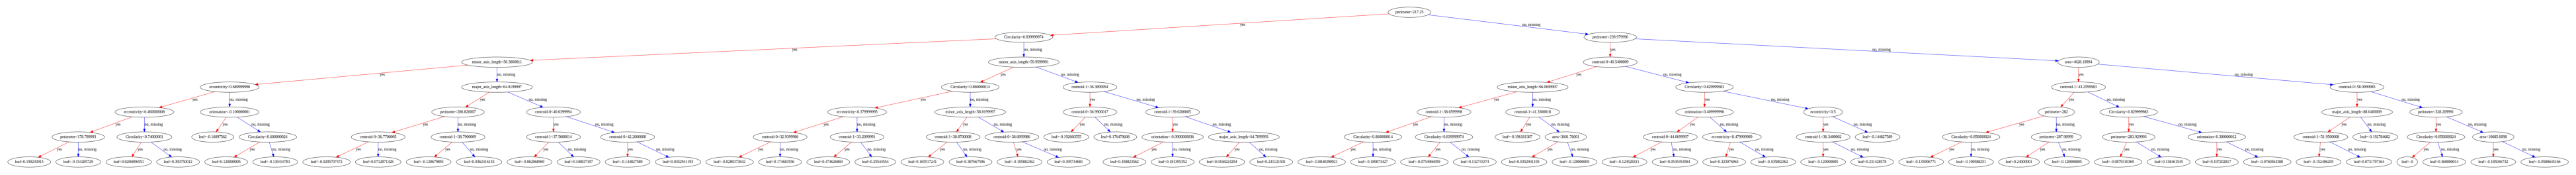

In [ ]:

from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 50,28
xgboost.plot_tree(clf)
plt.show()

In [ ]:
pip install bayesian-optimization

In [ ]:
def xgbc_cv(max_depth,learning_rate,n_estimators,reg_alpha,min_child_weight,colsample_bytree,gamma):
    from sklearn.metrics import roc_auc_score
    import numpy as np
    from sklearn.preprocessing import LabelBinarizer
    estimator_function = xgb.XGBClassifier(max_depth=int(max_depth),
                                           learning_rate= learning_rate,
                                           n_estimators= int(n_estimators),
                                           reg_alpha = reg_alpha,
                                           min_child_weight=min_child_weight,
                                           colsample_bytree=colsample_bytree,
                                           gamma=gamma,
                                          #  nthread = -1,
                                           objective='multi:softmax',
                                           num_class=3,
                                           seed = seed)
    estimator_function.fit(X_train,y_train)
    # fpr, tpr, roc_auc = dict(), dict(), dict()
    # # calculate out-of-the-box roc_score using validation set 1
    # probs = estimator_function.predict_proba(X_valid)
    # probs = probs[:,1]
    # val1_roc = roc_auc_score(y_valid,probs)
    y_pred = estimator_function.predict(X_test)

    # label_binarizer = LabelBinarizer().fit(y_train)
    # y_pred = label_binarizer.transform(y_pred)
    # y_true = label_binarizer.transform(y_test)

    # fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    # roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # calculate out-of-the-box roc_score using validation set 2
    # probs = estimator_function.predict_proba(X_valid2)
    # probs = probs[:,1]
    # val2_roc = roc_auc_score(y_valid2,probs)

    # return the mean validation score to be maximized
    # return np.array([val1_roc,val2_roc]).mean()
    # return roc_auc['micro']
    return metrics.accuracy_score(y_test, y_pred)
import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization
import xgboost as xgb
# alpha is a parameter for the gaussian process
# Note that this is itself a hyperparemter that can be optimized.
gp_params = {"alpha": 1e-10}

# We create the BayesianOptimization objects using the functions that utilize
# the respective classifiers and return cross-validated scores to be optimized.

seed = 42 # Random seed

# We create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.
# Note the syntax of bayes_opt package: bounds of hyperparameters are passed as two-tuples

hyperparameter_space = {
    'max_depth': (5, 20),
    'learning_rate': (0, 1),
    'n_estimators' : (10,100),
    'reg_alpha': (0,1),
    'min_child_weight': (1, 20),
    'colsample_bytree': (0.1, 1),
    'gamma' : (0,10)
}

xgbcBO = BayesianOptimization(f = xgbc_cv,
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points to establish a 'prior', then will perform
# 10 interations to maximize the value of estimator function
xgbcBO.maximize(init_points=7,n_iter=500)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.5912    | 0.4371    | 9.507     | 0.732     | 13.98     | 3.964     | 24.04     | 0.05808   |
| 2         | 0.5929    | 0.8796    | 6.011     | 0.7081    | 5.309     | 19.43     | 84.92     | 0.2123    |
| 3         | 0.6098    | 0.2636    | 1.834     | 0.3042    | 12.87     | 9.207     | 36.21     | 0.6119    |
| 4         | 0.5968    | 0.2255    | 2.921     | 0.3664    | 11.84     | 15.92     | 27.97     | 0.5142    |
| 5         | 0.6273    | 0.6332    | 0.4645    | 0.6075    | 7.558     | 2.236     | 95.4      | 0.9656    |
| 6         | 0.6115    | 0.8276    | 3.046     | 0.09767   | 15.26     | 9.363     | 20.98     | 0.4952    |
| 7         | 0.5389    | 0.1309    | 9.093     | 0.2588    | 14.94     | 6.923     | 56.81     | 0.5467    |
| 8       

In [ ]:
print(xgbcBO.max)

In [ ]:
clf=XGBClassifier(objective='multi:softmax',
                            num_class=3,
        learning_rate= 0.8709977472704522, max_depth= int( 7.716709596129787), n_estimators= int(35.90969750548409), reg_alpha=0.24610386160358344,
                   colsample_bytree= 0.5047465299438612, gamma=1.2030412953970793, min_child_weight=1.90728394928747,
                                          #  reg_alpha = 0.3259,
                                          seed = int(42),
                  # max_depth=int(14.97)
                                           )
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

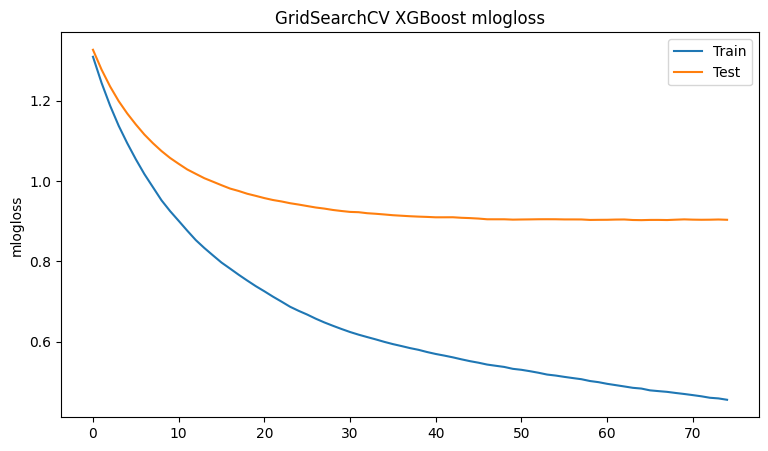

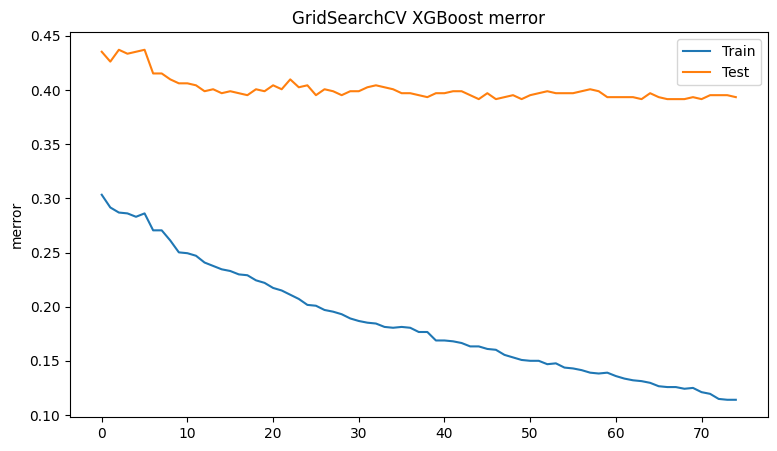


------------------ Confusion Matrix -----------------

[[ 96  10   9  18]
 [ 13  47  49  27]
 [  6  32  87  11]
 [  8  19  16 101]]

Accuracy: 0.60
Balanced Accuracy: 0.60

Micro Precision: 0.60
Micro Recall: 0.60
Micro F1-score: 0.60

Macro Precision: 0.60
Macro Recall: 0.60
Macro F1-score: 0.60

Weighted Precision: 0.60
Weighted Recall: 0.60
Weighted F1-score: 0.60

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       133
           1       0.44      0.35      0.39       136
           2       0.54      0.64      0.59       136
           3       0.64      0.70      0.67       144

    accuracy                           0.60       549
   macro avg       0.60      0.60      0.60       549
weighted avg       0.60      0.60      0.60       549

---------------------- XGBoost ----------------------


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,  classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
## ---------- XGBoost model v3 ----------
## third run of model with "optimized" hyperparameters and
## attempting to treat unbalanced target classes

# balancing 'target' class weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

# declaring and fitting xgb classifier
xgb_clf = XGBClassifier(objective='multi:softmax',
                            num_class=3,
                            missing=1,
                            gamma=0, # default gamma value
                            learning_rate=0.1,
                            max_depth=5, # re-optimized from v2
                            reg_lambda=1, # default L2 value
                            #subsample=0.8, # tried but not ideal
                            #colsample_bytree=0.3, # tried but not ideal
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)
xgb_clf.fit(X_train,
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            sample_weight=sample_weights, # class weights to combat unbalanced 'target'
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling

change init_points=20

In [ ]:
def xgbc_cv(max_depth,learning_rate,n_estimators,reg_alpha,min_child_weight,colsample_bytree,gamma):
    from sklearn.metrics import roc_auc_score
    import numpy as np

    estimator_function = xgb.XGBClassifier(max_depth=int(max_depth),
                                           learning_rate= learning_rate,
                                           n_estimators= int(n_estimators),
                                           reg_alpha = reg_alpha,
                                           min_child_weight=min_child_weight,
                                           colsample_bytree=colsample_bytree,
                                           gamma=gamma,
                                           nthread = -1,
                                           objective='binary:logistic',
                                           seed = seed)
    estimator_function.fit(X_train,y_train)

    # # calculate out-of-the-box roc_score using validation set 1
    # probs = estimator_function.predict_proba(X_valid)
    # probs = probs[:,1]
    # val1_roc = roc_auc_score(y_valid,probs)
    probs = estimator_function.predict_proba(X_test)
    probs = probs[:,1]
    val2_roc = roc_auc_score(y_test,probs)
    # calculate out-of-the-box roc_score using validation set 2
    # probs = estimator_function.predict_proba(X_valid2)
    # probs = probs[:,1]
    # val2_roc = roc_auc_score(y_valid2,probs)

    # return the mean validation score to be maximized
    # return np.array([val1_roc,val2_roc]).mean()
    return val2_roc.mean()
import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization
import xgboost as xgb
# alpha is a parameter for the gaussian process
# Note that this is itself a hyperparemter that can be optimized.
gp_params = {"alpha": 1e-10}

# We create the BayesianOptimization objects using the functions that utilize
# the respective classifiers and return cross-validated scores to be optimized.

seed = 112 # Random seed

# We create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.
# Note the syntax of bayes_opt package: bounds of hyperparameters are passed as two-tuples

hyperparameter_space = {
    'max_depth': (5, 20),
    'learning_rate': (0, 1),
    'n_estimators' : (10,100),
    'reg_alpha': (0,1),
    'min_child_weight': (1, 20),
    'colsample_bytree': (0.1, 1),
    'gamma' : (0,10)
}

xgbcBO = BayesianOptimization(f = xgbc_cv,
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points to establish a 'prior', then will perform
# 10 interations to maximize the value of estimator function
xgbcBO.maximize(init_points=20,n_iter=500)